## Libraries

In [22]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from datetime import datetime, timedelta, timezone
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re

In [24]:
!pip install 'pygeos==0.8' descartes geopy geopandas
import pkg_resources
pkg_resources.require("pygeos==0.8") 
import geopandas as gpd
from geopandas.tools import sjoin
import matplotlib.pyplot as plt
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
from shapely.geometry import Polygon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[pygeos 0.8 (/usr/local/lib/python3.7/dist-packages),
 numpy 1.21.6 (/usr/local/lib/python3.7/dist-packages)]

In [25]:
# functins to create sector polygon 
from geopy import distance

def get_point(lat, lng, bearing, dist):
    pt = distance.distance(kilometers=dist).destination((lat,lng),bearing)
    return pt.longitude, pt.latitude

def get_bearing(azi, hbw):
    h = hbw/2
    l = 0
    r = 0
    if (azi+h) > 360:
        r = (azi+h) - 360
    else:
        r = azi + h
    if (azi-h) < 0:
        l = 360 - ((azi-h)*-1)
    else:
        l = azi - h
    return l, r

def get_polygon_coords(lat, lng, azi, hbw, dist):
    l, r = get_bearing(azi, hbw)
    pt1 = get_point(lat, lng, l, dist)
    pt2 = get_point(lat, lng, azi, dist)
    pt3 = get_point(lat, lng, r, dist)
    return [(lng, lat), pt1, pt2, pt3, (lng, lat)]

def create_sector_poly(lat, lng, azi, hbw, dist):
    if pd.isna(lat) or pd.isna(lng):
      return np.nan
    coords = get_polygon_coords(lat, lng, azi, hbw, dist)
    return Polygon(coords)

# Load base file

In [17]:
#!ls "/content/drive/My Drive/Colab Notebooks/CGY CCO"

In [34]:
inputdir="/content/drive/My Drive/Analytics/GGCC-p1/Production Ref/"
inputfile="NE_Cell.csv"

outputdir="/content/drive/My Drive/Analytics/GGCC-p1/Production Ref/"

#startdate="2021-7-1"
#enddate="2021-7-11"

#start_date = datetime.strptime(startdate, '%Y-%m-%d')
#end_date = datetime.strptime(enddate, '%Y-%m-%d')

#cluster="EDM4"
#cluster="CGY3"

#base0 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CGY CCO/RFDB20210401.csv")
base0=pd.read_csv(inputdir+inputfile)
ColsToKeep=['Azimuth','Coverage_SiteID','ElementID','NodeName','PerformanceMarket','RAT','Sector','SiteLatitude','SiteLongitude']

base0=base0[ColsToKeep][base0.RAT=='LTE'].sort_values(by='Azimuth',ascending=True)
base0=base0.drop_duplicates('Sector')
base0=base0[base0['SiteLatitude'].isna()==False]
base0=base0.fillna(0)

#Canada's max/min for lat/lon
latMax = 83
latMin = 41
lonMax = -57
lonMin = -141

base0=base0[(base0['SiteLatitude'] > latMin) & (base0['SiteLatitude'] < latMax)]
base0=base0[(base0['SiteLongitude'] > lonMin) & (base0['SiteLongitude'] < lonMax)]

base0.shape
base0.head()

(27078, 9)

,Azimuth,Coverage_SiteID,ElementID,NodeName,PerformanceMarket,RAT,Sector,SiteLatitude,SiteLongitude
68706,0.0,ON1370,L-ON1370-BTS-03,LTHON0117059,Ottawa/Gatineau,LTE,ON1370-3,45.419880,-75.698990
99883,0.0,PQ3509,L-PQ3510-BTS-03,LTHQC0136718,Montreal Island,LTE,PQ3509-6,45.559810,-73.600097
99928,0.0,PQ3089,L-PQ3089-BTS-01,LTHQC0136816,Montreal Shores,LTE,PQ3089-1,45.631711,-73.646542
100023,0.0,PQ3427,L-PQ3427-BTS-01,LTHQC0136830,Montreal Island,LTE,PQ3427-1,45.472411,-73.601457
100024,0.0,PQ3427,L-PQ3427-BTS-01,LTHQC0136830,Montreal Island,LTE,PQ3427-2,45.472411,-73.601457


In [ ]:
base0[base0['Coverage_SiteID']=='AB1190']

,Azimuth,Coverage_SiteID,ElementID,NodeName,PerformanceMarket,RAT,Sector,SiteLatitude,SiteLongitude
10543,0.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-1,53.628277,-113.44243
10549,110.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-2,53.628277,-113.44243
10546,195.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-5,53.628277,-113.44243
10547,290.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-3,53.628277,-113.44243
10570,NaN,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-4,53.628277,-113.44243


In [35]:
base0['Azimuth']=base0['Azimuth'].fillna(0.99)
base0[base0['Coverage_SiteID']=='AB1190']

,Azimuth,Coverage_SiteID,ElementID,NodeName,PerformanceMarket,RAT,Sector,SiteLatitude,SiteLongitude
10541,0.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-1,53.628277,-113.44243
10544,110.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-2,53.628277,-113.44243
1284,195.0,AB1190,L-AB1190-BTS-02,LTHAB0100453,Edmonton,LTE,AB1190-5,53.628277,-113.44243
10555,290.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-3,53.628277,-113.44243
10572,0.0,AB1190,L-AB1190-BTS-01,LTHAB0113476,Edmonton,LTE,AB1190-4,53.628277,-113.44243


In [36]:
base0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27078 entries, 68706 to 140741
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Azimuth            27078 non-null  float64
 1   Coverage_SiteID    27078 non-null  object 
 2   ElementID          27078 non-null  object 
 3   NodeName           27078 non-null  object 
 4   PerformanceMarket  27078 non-null  object 
 5   RAT                27078 non-null  object 
 6   Sector             27078 non-null  object 
 7   SiteLatitude       27078 non-null  float64
 8   SiteLongitude      27078 non-null  float64
dtypes: float64(3), object(6)
memory usage: 2.1+ MB


In [37]:
base0=base0.rename(columns={'SiteLatitude':'Latitude','SiteLongitude':'Longitude','Azimuth':'Orientation'})
base0.head(1)

,Orientation,Coverage_SiteID,ElementID,NodeName,PerformanceMarket,RAT,Sector,Latitude,Longitude
68706,0.0,ON1370,L-ON1370-BTS-03,LTHON0117059,Ottawa/Gatineau,LTE,ON1370-3,45.41988,-75.69899


# Create sector polygons

,Orientation,Coverage_SiteID,ElementID,NodeName,PerformanceMarket,RAT,Sector,Latitude,Longitude,geometry
68706,0.0,ON1370,L-ON1370-BTS-03,LTHON0117059,Ottawa/Gatineau,LTE,ON1370-3,45.419880,-75.698990,"POLYGON ((-75.69899 45.41988, -75.69920 45.420..."
99883,0.0,PQ3509,L-PQ3510-BTS-03,LTHQC0136718,Montreal Island,LTE,PQ3509-6,45.559810,-73.600097,"POLYGON ((-73.60010 45.55981, -73.60030 45.560..."
99928,0.0,PQ3089,L-PQ3089-BTS-01,LTHQC0136816,Montreal Shores,LTE,PQ3089-1,45.631711,-73.646542,"POLYGON ((-73.64654 45.63171, -73.64675 45.631..."
100023,0.0,PQ3427,L-PQ3427-BTS-01,LTHQC0136830,Montreal Island,LTE,PQ3427-1,45.472411,-73.601457,"POLYGON ((-73.60146 45.47241, -73.60166 45.472..."
100024,0.0,PQ3427,L-PQ3427-BTS-01,LTHQC0136830,Montreal Island,LTE,PQ3427-2,45.472411,-73.601457,"POLYGON ((-73.60146 45.47241, -73.60166 45.472..."


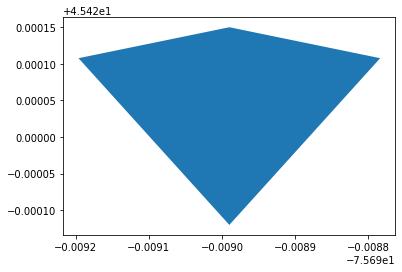

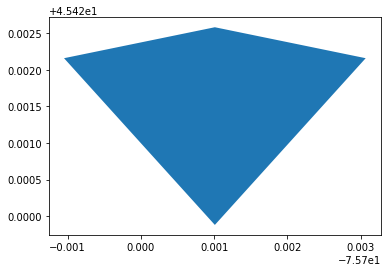

In [38]:
r = 0.03 #km
r_max=0.3 #km 
bw = 65
base_max=base0.copy()
base0["geometry"] = base0.apply(lambda x : create_sector_poly(x.Latitude, x.Longitude, x.Orientation, bw, r), axis = 1)
base_max["geometry"] = base_max.apply(lambda x : create_sector_poly(x.Latitude, x.Longitude, x.Orientation, bw, r_max), axis = 1)
gdf_sector = gpd.GeoDataFrame(base0, geometry='geometry')
gdf_sector_max = gpd.GeoDataFrame(base_max, geometry='geometry')
gdf_sector.head()
gdf_sector.head(1).plot()
gdf_sector_max.head(1).plot()

# Export results

In [39]:
gdf_sector.to_file(outputdir + "RFDB"+".json", driver='GeoJSON')
gdf_sector.to_file(outputdir + "RFDB"+".kml", driver='KML')
gdf_sector_max.to_file(outputdir + "RFDB_max"+".json", driver='GeoJSON')
gdf_sector_max.to_file(outputdir + "RFDB_max"+".kml", driver='KML') 